<a href="https://colab.research.google.com/github/rahiakela/computer-vision-case-studies/blob/master/object-detections/r-cnn-object-detection-series/1_turning_cnn_image_classifier_into_object_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Turning CNN image classifier into an object detector

The goal of this series of posts is to obtain a deeper understanding of how deep learning-based object detectors work, and more specifically:

1. How traditional computer vision object detection algorithms can be combined with deep learning
2. What the motivations behind end-to-end trainable object detectors and the challenges associated with them are
3. And most importantly, how the seminal Faster R-CNN architecture came to be (we’ll be building a variant of the R-CNN architecture throughout this series).

Today, we’ll be starting with the fundamentals of object detection, including how to take a pre-trained image classifier and utilize image pyramids, sliding windows, and non-maxima suppression to build a basic object detector (think HOG + Linear SVM-inspired).

Over the coming weeks, we’ll learn how to build an end-to-end trainable network from scratch.

But for today, let’s start with the basics.

## Setup

In [1]:
# import the necessary packages
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import imagenet_utils
from imutils.object_detection import non_max_suppression
import numpy as np
import argparse
import imutils
import time
import cv2
from google.colab.patches import cv2_imshow

In [2]:
%%shell

wget -q https://github.com/rahiakela/computer-vision-case-studies/raw/master/object-detections/r-cnn-object-detection-series/images/hummingbird.jpg
wget -q https://github.com/rahiakela/computer-vision-case-studies/raw/master/object-detections/r-cnn-object-detection-series/images/lawn_mower.jpg
wget -q https://github.com/rahiakela/computer-vision-case-studies/raw/master/object-detections/r-cnn-object-detection-series/images/stingray.jpg

## Image classification vs. object detection

<img src='https://www.pyimagesearch.com/wp-content/uploads/2018/05/gentle_guide_obj_det_cls_vs_det.jpg?raw=1' width='800'/>

> Left: Image classification. Right: Object detection. In this blog post, we will learn how to turn any deep learning image classifier CNN into an object detector with Keras, TensorFlow, and OpenCV.

When performing **image classification**, given an input image, we present it to our neural network, and we obtain a single class label and a probability associated with the class label prediction.

This class label is meant to characterize the contents of the entire image, or at least the most dominant, visible contents of the image.

We can thus think of image classification as:

- One image in
- One class label out

**Object detection**, on the other hand, not only tells us what is in the image (i.e., class label) but also where in the image the object is via bounding box (x, y)-coordinates.

Therefore, object detection algorithms allow us to:

- Input one image
- Obtain multiple bounding boxes and class labels as output

At the very core, any object detection algorithm (regardless of traditional computer vision or state-of-the-art deep learning), follows the same pattern:

1. **Input**: An image that we wish to apply object detection to
2. **Output**: Three values, including:
 - A list of bounding boxes, or the (x, y)-coordinates for each object in an image
 - The class label associated with each of the bounding boxes
 - The probability/confidence score associated with each bounding box and class label



## Turn any deep learning image classifier into an object detector

Anyone who has read papers on Faster R-CNN, Single Shot Detectors (SSDs), YOLO, RetinaNet, etc. knows that object detection networks are more complex, more involved, and take multiple orders of magnitude and more effort to implement compared to traditional image classification.

**That said, there is a hack we can leverage to turn our CNN image classifier into an object detector — and the secret sauce lies in traditional computer vision algorithms.**

Back before deep learning-based object detectors, the state-of-the-art was to use [HOG + Linear SVM](https://www.pyimagesearch.com/2014/11/10/histogram-oriented-gradients-object-detection/) to detect objects in an image.

We’ll be borrowing elements from HOG + Linear SVM to convert any deep neural network image classifier into an object detector.

**The first key ingredient from HOG + Linear SVM is to use image pyramids.**

An “image pyramid” is a multi-scale representation of an image:

<img src='https://www.pyimagesearch.com/wp-content/uploads/2020/06/keras_classifier_object_detector_pyramid_example_2.png?raw=1' width='800'/>

> Image pyramids allow us to produce images at different scales. When turning an image classifier into an object detector, it is important to classify windows at multiple scales. We will learn how to write an image pyramid Python generator and put it to work in our Keras, TensorFlow, and OpenCV script.

Utilizing an image pyramid allows us to find objects in images at different scales (i.e., sizes) of an image.

At the bottom of the pyramid, we have the original image at its original size (in terms of width and height).

And at each subsequent layer, the image is resized (subsampled) and optionally smoothed (usually via Gaussian blurring).

The image is progressively subsampled until some stopping criterion is met, which is normally when a minimum size has been reached and no further subsampling needs to take place.

**The second key ingredient we need is sliding windows:**

<img src='https://www.pyimagesearch.com/wp-content/uploads/2014/10/sliding_window_example.gif?raw=1' width='800'/>

> We will classify regions of our multi-scale image representations. These regions are generated by means of sliding windows. The combination of image pyramids and sliding windows allow us to turn any image classifier into an object detector using Keras, TensorFlow, and OpenCV.

As the name suggests, a sliding window is a fixed-size rectangle that slides from left-to-right and top-to-bottom within an image. (As Figure demonstrates, our sliding window could be used to detect the face in the input image).

At each stop of the window we would:

- Extract the ROI
- Pass it through our image classifier (ex., Linear SVM, CNN, etc.)
- Obtain the output predictions

**The final key ingredient we need is non-maxima suppression.**

When performing object detection, our object detector will typically produce multiple, overlapping bounding boxes surrounding an object in an image.


<img src='https://www.pyimagesearch.com/wp-content/uploads/2020/06/keras_classifier_object_detector_result01_before_nms.jpg?raw=1' width='800'/>

> One key ingredient to turning a CNN image classifier into an object detector with Keras, TensorFlow, and OpenCV is applying a process known as non-maxima suppression (NMS). We will use NMS to suppress weak, overlapping bounding boxes in favor of higher confidence predictions.

This behavior is totally normal — it simply implies that as the sliding window approaches an image, our classifier component is returning larger and larger probabilities of a positive detection.

Of course, multiple bounding boxes pose a problem — there’s only one object there, and we somehow need to collapse/remove the extraneous bounding boxes.

The solution to the problem is to apply non-maxima suppression (NMS), which collapses weak, overlapping bounding boxes in favor of the more confident ones:


<img src='https://www.pyimagesearch.com/wp-content/uploads/2020/06/keras_classifier_object_detector_result01_after_nms.jpg?raw=1' width='800'/>

> After non-maxima suppression (NMS) has been applied, we’re left with a single detection for each object in the image. TensorFlow, Keras, and OpenCV allow us to turn a CNN image classifier into an object detector.

On the left, we have multiple detections, while on the right, we have the output of non-maxima suppression, which collapses the multiple bounding boxes into a single detection.


## Combining traditional computer vision with deep learning to build an object detector

<img src='https://www.pyimagesearch.com/wp-content/uploads/2020/06/keras_classifier_object_detector_steps.png?raw=1' width='800'/>

> The steps to turn a deep learning classifier into an object detector using Python and libraries such as TensorFlow, Keras, and OpenCV.

In order to take any Convolutional Neural Network trained for image classification and instead utilize it for object detection, we’re going to utilize the three key ingredients for traditional computer vision:

- **Image pyramids**: Localize objects at different scales/sizes.
- **Sliding windows**: Detect exactly where in the image a given object is.
- **Non-maxima suppression**: Collapse weak, overlapping bounding boxes.

The general flow of our algorithm will be:

- **Step #1**: Input an image
- **Step #2**: Construct an image pyramid
- **Step #3**: For each scale of the image pyramid, run a sliding window
 - **Step #3a**: For each stop of the sliding window, extract the ROI
 - **Step #3b**: Take the ROI and pass it through our CNN originally trained for image classification
 - **Step #3c**: Examine the probability of the top class label of the CNN, and if meets a minimum confidence, record (1) the class label and (2) the location of the sliding window
- **Step #4**: Apply class-wise non-maxima suppression to the bounding boxes
- **Step #5**: Return results to calling function

That may seem like a complicated process, but as you’ll see in the remainder of this post, we can implement the entire object detection procedure in < 200 lines of code!

## Implementing image pyramid and sliding window

We are goining to create two helper functions:

- `image_pyramid`: Assists in generating copies of our image at different scales so that we can find objects of different sizes
- `sliding_window`: Helps us find where in the image an object is by sliding our classification window from left-to-right (column-wise) and top-to-bottom (row-wise)

The helper functions accomplishes object detection by means of a classifier (using a sliding window and image pyramid approach). The classifier we’re using is a pre-trained ResNet50 CNN trained on the ImageNet dataset. The ImageNet dataset consists of 1,000 classes of objects.

In order to turn our CNN image classifier into an object detector, we must first implement helper utilities to construct sliding windows and image pyramids.

Let’s implement this helper functions now.

In [3]:
def sliding_window(image, step, ws):
  """
  image: The image that loop over and generate windows from. This image may come from the output of image pyramid.
  step: Step size, which indicates how many pixels we are going to “skip” in both the (x, y) directions.Remember, the smaller
       step size is, the more windows you’ll need to examine.
  ws: The window size defines the width and height (in pixels) of the window we are going to extract from image
  """
  # slide a window across the image
  for y in range(0, image.shape[0] - ws[1], step):    # loop over rows via determining a range of y-values.
    for x in range(0, image.shape[1] - ws[0], step):  #  loop over columns (a range of x-values).
      # yield the current window
      # ultimately yields the window of image (i.e., ROI) according to the (x, y)-values, window size (ws), and step size.
      yield (x, y, image[y: y + ws[1], x: x + ws[0]]) 

The yield keyword is used in place of the return keyword because our sliding_window function is implemented as a Python generator.

For more information on our sliding windows implementation, please refer to my previous [Sliding Windows for Object Detection with Python and OpenCV](https://www.pyimagesearch.com/2015/03/23/sliding-windows-for-object-detection-with-python-and-opencv/) article.

Now that we’ve successfully defined our sliding window routine, let’s implement our image_pyramid generator used to construct a multi-scale representation of an input image:

In [4]:
def image_pyramid(image, scale=1.5, min_size=(224, 224)):
  """
  image: The input image for which we wish to generate multi-scale representations.
  scale: scale factor controls how much the image is resized at each layer. 
         Smaller scale values yield more layers in the pyramid, and larger scale values yield fewer layers.
  minSize: Controls the minimum size of an output image (layer of pyramid).
  """
  # yield the original/unaltered image, the first time
  yield image   

  # keep looping over the image pyramid
  while True:
    # compute the dimensions of the next image in the pyramid
    w = int(image.shape[1] / scale)
    # resize the image down to the width while maintaining aspect ratio
    image = imutils.resize(image, width=w)

    # if the resized image does not meet the supplied minimum size, then stop constructing the pyramid
    if image.shape[0] < min_size[1] or image.shape[1] < min_size[0]:
      break

    # yield the next image in the pyramid
    yield image

For more details, please refer to my [Image Pyramids with Python and OpenCV](https://www.pyimagesearch.com/2015/03/16/image-pyramids-with-python-and-opencv/) article, which also includes an alternative scikit-image image pyramid implementation that may be useful to you.

## Turn a pre-trained image classifier into an object detector

With our sliding_window and image_pyramid functions implemented, let’s now use them to take a deep neural network trained for image classification and turn it into an object detector.

We now have a handful of constants to define for our object detection procedures:

In [5]:
# initialize variables used for the object detection procedure
WIDTH = 600
PYR_SCALE = 1.5              # image pyramid scale factor
WIN_STEP = 16                # sliding window step size, which indicates how many pixels we are going to “skip” in both the (x, y) directions.
INPUT_SIZE = (224, 224)      # The classification CNN dimensions

Understanding what each of the above constants controls is crucial to your understanding of how to turn an image classifier into an object detector with Keras, TensorFlow, and OpenCV. Be sure to mentally distinguish each of these before moving on.

- **Step-1**: Let’s load our ResNet classification CNN and input image

- **Step-2**: From here, we’re ready to initialize our image pyramid generator object

- **Step-3**: Let’s loop over each image our pyramid produces. Now we’ll cascade into our sliding window loop from this particular layer in our image pyramid. Our sliding_window generator allows us to look side-to-side and up-and-down in our image. For each ROI that it generates, we’ll soon apply image classification.

- **Step-4**: We also handle optional visualization.Here, we visualize both the original image with a green box indicating where we are “looking” and the resized ROI, which is ready for classification.

- **Step-5**: 
 - Next, we’ll (1) check our benchmark on the pyramid + sliding window process, (2) classify all of our rois in batch, and (3) decode predictions
 - Then, we take the ROIs and pass them (in batch) through our pre-trained image classifier (i.e., ResNet) via predict.
 -Finally, decodes the predictions, grabbing only the top prediction for each ROI.
 - We’ll need a means to map class labels (keys) to ROI locations associated with that label (values); the labels dictionary serves that purpose.

- **Step-6**: Let’s go ahead and populate our labels dictionary now.
 - Looping over predictions, we first grab the prediction information including the ImageNet ID, class label, and probability.
 - From there, we check to see if the minimum confidence has been met. Assuming so, we update the labels dictionary with the bounding box and prob score tuple (value) associated with each class label (key).

- **Step-7**: This is the time where you would implement logic to do something useful with the results (labels), whereas in our case, we’re simply going to annotate the objects. We will also have to handle our overlapping detections by means of non-maxima suppression (NMS).
 - We make a copy of the original input image so that we can annotate it
 - We then annotate all bounding boxes for the current label
 - So that we can visualize the before/after applying NMS, and then we proceed to make another copy.



In [9]:
def detect_with_classify(image, img_size, min_conf=0.90, visualize=0):
  # Controls the aspect ratio of the objects we want to detect
  ROI_SIZE = img_size

  # Step-1: load our the network weights from disk
  print("[INFO] loading network...")
  model = ResNet50(weights="imagenet", include_top=True)

  # load the input image from disk, resize it such that it has the
  # has the supplied width, and then grab its dimensions
  orig = cv2.imread(image)
  orig = imutils.resize(orig, width=WIDTH)
  (H, W) = orig.shape[:2]    # grab resulting image dimensions.

  # Step-2: initialize image pyramid generator object
  pyramid = image_pyramid(orig, scale=PYR_SCALE, min_size=ROI_SIZE)

  # initialize two lists, one to hold the ROIs generated from the image pyramid and sliding window, 
  # and another list used to store the (x, y)-coordinates of where the ROI was in the original image
  rois = []
  locs = []

  # time how long it takes to loop over the image pyramid layers and sliding window locations
  start = time.time()

  # Step-3: loop over the image pyramid
  for image in pyramid:
    # determine the scale factor between the *original* image dimensions and the *current* layer of the pyramid
    scale = W / float(image.shape[1])

    # for each layer of the image pyramid, loop over the sliding window locations
    for (x, y, roi_orig) in sliding_window(image, WIN_STEP, ROI_SIZE):
      # scale the (x, y)-coordinates of the ROI with respect to the *original* image dimensions
      x = int(x * scale)
      y = int(y * scale)
      w = int(ROI_SIZE[0] * scale)
      h = int(ROI_SIZE[1] * scale)

      # take the ROI and preprocess it so we can later classify the region using Keras/TensorFlow
      roi = cv2.resize(roi_orig, INPUT_SIZE)
      roi = img_to_array(roi)
      roi = preprocess_input(roi)

      # update our list of ROIs and associated coordinates
      rois.append(roi)
      locs.append((x, y, x + w, y + h))

      # Step-4: check to see if we are visualizing each of the sliding windows in the image pyramid
      if visualize > 0:
        # clone the original image and then draw a bounding box surrounding the current region
        cloned = orig.copy()
        cv2.rectangle(cloned, (x, y), (x +w, y + h), (0, 255, 0), 2)
        # show the visualization and current ROI
        cv2_imshow(cloned)
        cv2_imshow(roi_orig)
        #cv2.waitKey(0)
     
  """
  Next, we’ll (1) check our benchmark on the pyramid + sliding window process, (2) classify all of our rois in batch, and (3) decode predictions
  """
  # show how long it took to loop over the image pyramid layers and sliding window locations
  end = time.time()
  print("[INFO] looping over pyramid/windows took {:.5f} seconds".format(end - start))

  # convert the ROIs to a NumPy array
  rois = np.array(rois, dtype="float32")

  # classify each of the proposal ROIs using ResNet and then show how long the classifications took
  print("[INFO] classifying ROIs...")
  start = time.time()
  preds = model.predict(rois)
  end = time.time()
  print("[INFO] classifying ROIs took {:.5f} seconds".format(end - start))

  #  Step-5: decode the predictions and initialize a dictionary which maps class labels (keys) to any ROIs associated with that label (values)
  preds = imagenet_utils.decode_predictions(preds, top=1)
  labels = {}
  # loop over the predictions
  for (i, p) in enumerate(preds):
    # grab the prediction information for the current ROI
    (imagenetID, label, prob) = p[0]

    # filter out weak detections by ensuring the predicted probability is greater than the minimum probability
    if prob >= min_conf:
      # grab the bounding box associated with the prediction and convert the coordinates
      box = locs[i]

      # grab the list of predictions for the label and add the bounding box and probability to the list
      L = labels.get(label, [])
      L.append((box, prob))
      labels[label] = L

  """
  This is the time where you would implement logic to do something useful with the results (labels), whereas in our case, we’re simply going to annotate the objects.
  We will also have to handle our overlapping detections by means of non-maxima suppression (NMS).
  """
  # Step-6: loop over the labels for each of detected objects in the image
  for label in labels.keys():
    # clone the original image so that we can draw on it
    print("[INFO] showing results for '{}'".format(label))
    clone = orig.copy()
    
    # loop over all bounding boxes for the current label
    for (box, prob) in labels[label]:
      # draw the bounding box on the image
      (startX, startY, endX, endY) = box
      cv2.rectangle(clone, (startX, startY), (endX, endY), (0, 255, 0), 2)

    # show the results *before* applying non-maxima suppression, then clone the image again so we can display the results *after* applying non-maxima suppression
    cv2_imshow(clone)
    clone = orig.copy()

    # Step-6: extract the bounding boxes and associated prediction probabilities, then apply non-maxima suppression
    boxes = np.array([p[0] for p in labels[label]])
    proba = np.array([p[1] for p in labels[label]])
    boxes = non_max_suppression(boxes, proba)

    # loop over all bounding boxes that were kept after applying non-maxima suppression
    for (startX, startY, endX, endY) in boxes:
      # draw the bounding box and label on the image
      cv2.rectangle(clone, (startX, startY), (endX, endY), (0, 255, 0), 2)
      y = startY - 10 if startY - 10 > 10 else startY + 10
      cv2.putText(clone, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0,255, 0), 2)

    # show the output after apply non-maxima suppression
    cv2_imshow(clone)

As a recap, so far, we have:

- Generated scaled images with our image pyramid
- Generated ROIs using a sliding window approach for each layer (scaled image) of our image pyramid
- Performed classification on each ROI and placed the results in our labels list

To apply NMS, we first extract the bounding boxes and associated prediction probabilities (proba). We then pass those results into my imultils implementation of NMS. For more details on non-maxima suppression, be sure to refer to [blog post](https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/).

After NMS has been applied, the annotated bounding box rectangles and labels on the “after” image. it display the results until a key is pressed, at which point all GUI windows close, and the script exits.

## Testing object detector

At this point, we are ready to see the results of our hard work.



[INFO] loading network...
[INFO] looping over pyramid/windows took 0.19436 seconds
[INFO] classifying ROIs...
[INFO] classifying ROIs took 37.22350 seconds
[INFO] showing results for 'stingray'


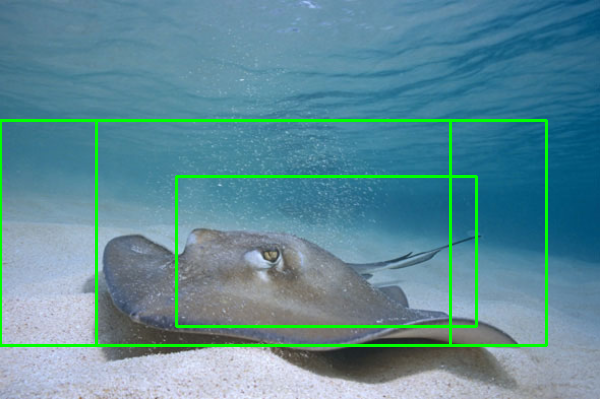

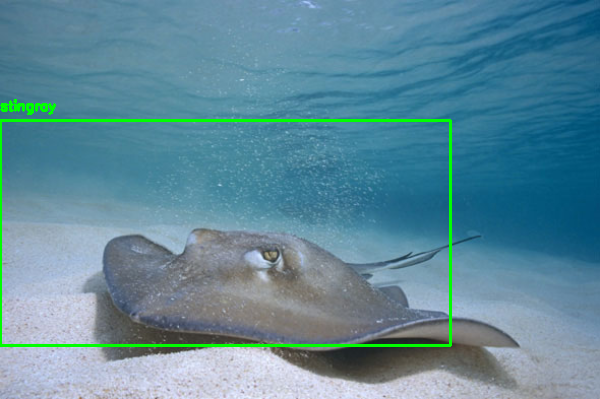

In [10]:
detect_with_classify(image="stingray.jpg", img_size=(300, 150))

Here, you can see that I have inputted an example image containing a “stingray” which CNNs trained on ImageNet will be able to recognize (since ImageNet contains a “stingray” class).

Notice how there are multiple, overlapping bounding boxes surrounding the stingray.

Applying non-maxima suppression collapses the bounding boxes into a single detection.

Let’s try another image, this one of a hummingbird (again, which networks trained on ImageNet will be able to recognize):

[INFO] loading network...
[INFO] looping over pyramid/windows took 0.09610 seconds
[INFO] classifying ROIs...
[INFO] classifying ROIs took 14.08657 seconds
[INFO] showing results for 'hummingbird'


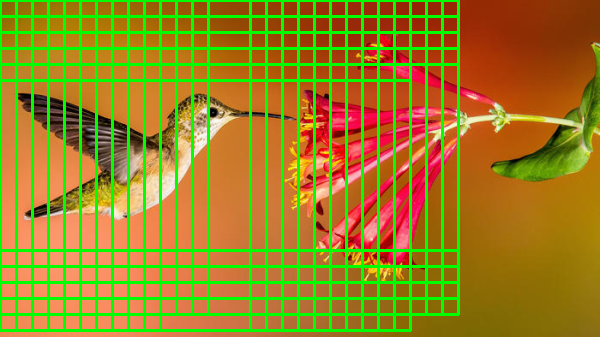

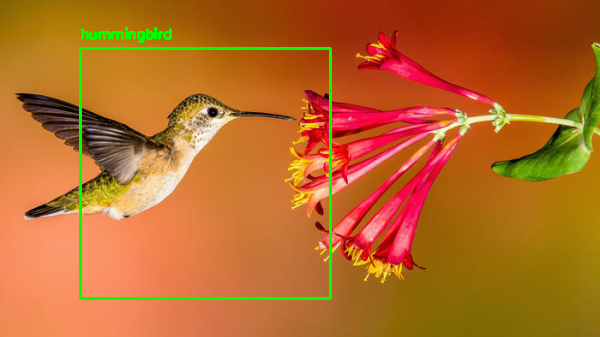

In [11]:
detect_with_classify(image="hummingbird.jpg", img_size=(250, 250))

Again, our “image classifier turned object detector” procedure performed well here.

But let’s now try an example image where our object detection algorithm doesn’t perform optimally:

[INFO] loading network...
[INFO] looping over pyramid/windows took 0.15175 seconds
[INFO] classifying ROIs...
[INFO] classifying ROIs took 25.65282 seconds
[INFO] showing results for 'lawn_mower'


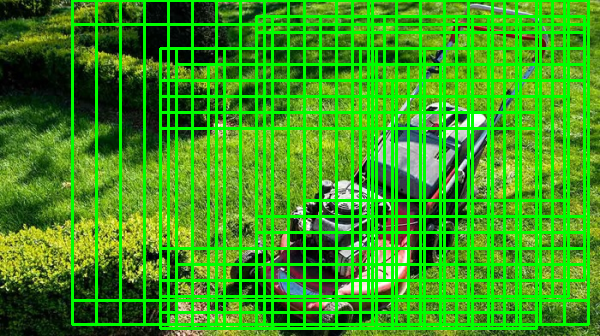

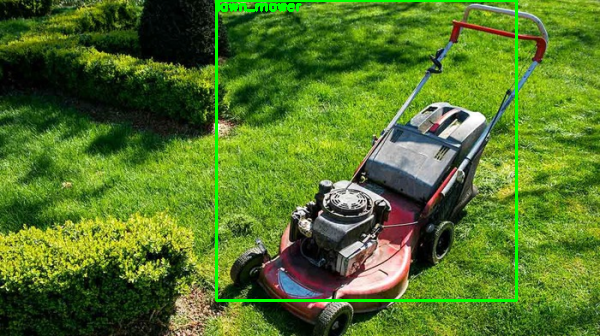

[INFO] showing results for 'half_track'


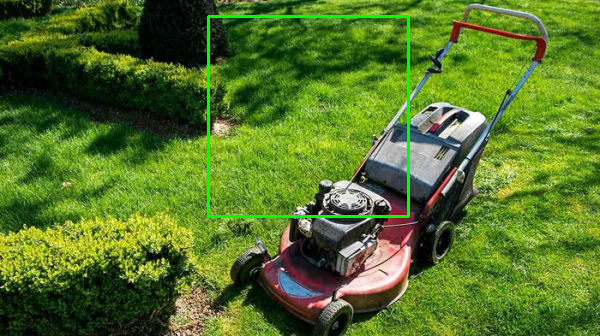

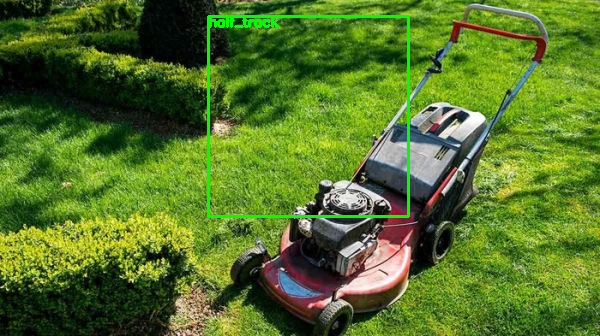

In [12]:
detect_with_classify(image="lawn_mower.jpg", img_size=(200, 200))

At first glance, it appears this method worked perfectly — we were able to localize the “lawn mower” in the input image.

But there was actually a second detection for a “half-track” (a military vehicle that has regular wheels on the front and tank-like tracks on the back):

The answer is to increase our `--min-conf` to remove false-positive predictions:

[INFO] loading network...
[INFO] looping over pyramid/windows took 0.15580 seconds
[INFO] classifying ROIs...
[INFO] classifying ROIs took 26.61234 seconds
[INFO] showing results for 'lawn_mower'


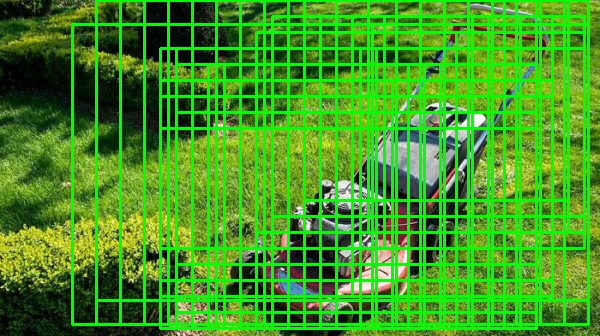

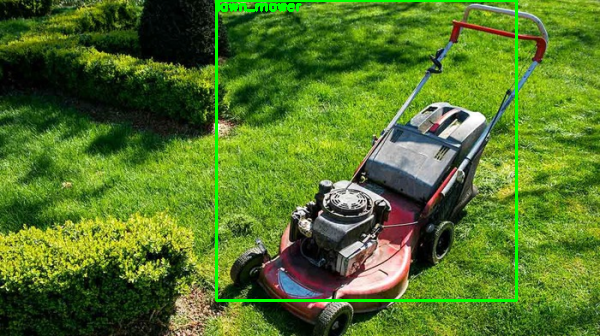

In [13]:
detect_with_classify(image="lawn_mower.jpg", img_size=(200, 200), min_conf=0.95)

By increasing the minimum confidence to 95%, we have filtered out the less confident “half-track” prediction, leaving only the (correct) “lawn mower” object detection.

While our procedure for turning a pre-trained image classifier into an object detector isn’t perfect, it still can be used for certain situations, specifically when images are captured in controlled environments.

##Problems, limitations, and next steps

If you carefully inspect the results of our object detection procedure, you’ll notice a few key takeaways:

- **The actual object detector is slow**. Constructing all the image pyramid and sliding window locations takes ~1/10th of a second, and that doesn’t even include the time it takes for the network to make predictions on all the ROIs (4-9 seconds on a 3 GHz CPU)!
- **Bounding box locations aren’t necessarily accurate**. The largest issue with this object detection algorithm is that the accuracy of our detections is dependent on our selection of image pyramid scale, sliding window step, and ROI size. If any one of these values is off, then our detector is going to perform suboptimally.
- **The network is not end-to-end trainable**. The reason deep learning-based object detectors such as Faster R-CNN, SSDs, YOLO, etc. perform so well is because they are end-to-end trainable, meaning that any error in bounding box predictions can be made more accurate through backpropagation and updating the weights of the network — since we’re using a pre-trained image classifier with fixed weights, we cannot backpropagate error terms through the network.